# Pandas怎样实现groupby分组统计  

类似SQL： 
select city, max(temperature) from city_weather group by city;

groupby: 先对数据分组，然后每个分组上应用聚合函数、转换函数

本次演示： 
 1. 分组使用聚合函数做数据统计
 2. 遍历groupby的结果理解执行流程
 3. 实例分组探索天气数据
 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df=pd.DataFrame({'A':['foo','bar','foo','bar','foo','bar','foo','foo'],
                 'B':['one','one','two','three','two','two','one','three'],
                 'C': np.random.randn(8),
                 'D': np.random.randn(8)
                })
df

A      B         C         D
0  foo    one -0.436025  0.562256
1  bar    one  1.038891  1.460787
2  foo    two  0.560114  1.785082
3  bar  three  0.142345  1.634073
4  foo    two  0.125157 -2.323401
5  bar    two  0.874954 -0.071034
6  foo    one -0.399645 -0.944232
7  foo  three -0.098319  0.875835

## 一、分组使用聚合函数做数据统计

**1.单个列groupby，查询所有数据列的统计**

In [3]:
df.groupby('A').sum()

C         D
A                      
bar  2.056190  3.023826
foo -0.248717 -0.044461

我们可以看到：  
 1. groupby中的'A'变成了数据的索引列
 2. 因为要统计sum，但B列不是数字，所以会被自动忽略掉

**2. 多个列groupby，查询所有数据列的统计**

In [4]:
df.groupby(['A','B']).mean()

C         D
A   B                        
bar one    1.038891  1.460787
    three  0.142345  1.634073
    two    0.874954 -0.071034
foo one   -0.417835 -0.190988
    three -0.098319  0.875835
    two    0.342636 -0.269160

我们看到：（’A‘，’B‘）变成了二级索引

In [5]:
df.groupby(['A','B'], as_index=False).mean()

A      B         C         D
0  bar    one  1.038891  1.460787
1  bar  three  0.142345  1.634073
2  bar    two  0.874954 -0.071034
3  foo    one -0.417835 -0.190988
4  foo  three -0.098319  0.875835
5  foo    two  0.342636 -0.269160

**3. 同时查看多种数据统计**

In [6]:
df.groupby('A').agg([np.sum,np.mean,np.std])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar  2.056190  0.685397  0.477387  3.023826  1.007942  0.938429
foo -0.248717 -0.049743  0.411254 -0.044461 -0.008892  1.624739

如此，列就变成了多级索引

**4. 查看单列的结果数据统计**

In [7]:
df.groupby('A')['C'].agg([np.sum,np.mean,np.std])

sum      mean       std
A                                
bar  2.056190  0.685397  0.477387
foo -0.248717 -0.049743  0.411254

In [8]:
df.groupby('A').agg([np.sum,np.mean,np.std])['C']

sum      mean       std
A                                
bar  2.056190  0.685397  0.477387
foo -0.248717 -0.049743  0.411254

In [10]:
df.groupby('A').agg({'C':np.mean, 'D':[np.max, np.mean]})

C         D          
         mean      amax      mean
A                                
bar  0.685397  1.634073  1.007942
foo -0.049743  1.785082 -0.008892

## 二、遍历groupby的结果理解执行流程  

for遍历可以直接遍历每个group

**1.遍历单个列聚合的分组**

In [11]:
g= df.groupby('A')
g

In [13]:
for name,group in g:
    print(name)
    print(group)
    print()

bar
     A      B         C         D
1  bar    one  1.038891  1.460787
3  bar  three  0.142345  1.634073
5  bar    two  0.874954 -0.071034

foo
     A      B         C         D
0  foo    one -0.436025  0.562256
2  foo    two  0.560114  1.785082
4  foo    two  0.125157 -2.323401
6  foo    one -0.399645 -0.944232
7  foo  three -0.098319  0.875835



**可以获取单个分组的数据**

In [14]:
g.get_group('bar')

A      B         C         D
1  bar    one  1.038891  1.460787
3  bar  three  0.142345  1.634073
5  bar    two  0.874954 -0.071034

**2.遍历多个列聚合的分组**

In [15]:
g=df.groupby(['A','B'])

In [16]:
for name, group in g:
    print(name)
    print(group)
    print()

('bar', 'one')
     A    B         C         D
1  bar  one  1.038891  1.460787

('bar', 'three')
     A      B         C         D
3  bar  three  0.142345  1.634073

('bar', 'two')
     A    B         C         D
5  bar  two  0.874954 -0.071034

('foo', 'one')
     A    B         C         D
0  foo  one -0.436025  0.562256
6  foo  one -0.399645 -0.944232

('foo', 'three')
     A      B         C         D
7  foo  three -0.098319  0.875835

('foo', 'two')
     A    B         C         D
2  foo  two  0.560114  1.785082
4  foo  two  0.125157 -2.323401



可以看到，name是一个两个元素的tuple，代表不同的列

In [17]:
g.get_group(('foo','three'))

A      B         C         D
7  foo  three -0.098319  0.875835

**可以直接查询group后的某激烈，生产Series或者sub dataframe

In [18]:
g['C']

In [20]:
for name, group in g['C']:
    print(name)
    print(group)
    print(type(group))

('bar', 'one')
1    1.038891
Name: C, dtype: float64
<class 'pandas.core.series.Series'>
('bar', 'three')
3    0.142345
Name: C, dtype: float64
<class 'pandas.core.series.Series'>
('bar', 'two')
5    0.874954
Name: C, dtype: float64
<class 'pandas.core.series.Series'>
('foo', 'one')
0   -0.436025
6   -0.399645
Name: C, dtype: float64
<class 'pandas.core.series.Series'>
('foo', 'three')
7   -0.098319
Name: C, dtype: float64
<class 'pandas.core.series.Series'>
('foo', 'two')
2    0.560114
4    0.125157
Name: C, dtype: float64
<class 'pandas.core.series.Series'>


其实所有的聚合统计，都是在dtaframe和series上进行的

## 三、实例分组探索天气数据

In [27]:
fpath='./datas/beijing_tianqi/beijing_tianqi_2018.csv'
df = pd.read_csv(fpath)
df

ymd bWendu yWendu tianqi fengxiang fengli  aqi aqiInfo  aqiLevel
0    2018-01-01     3℃    -6℃   晴~多云       东北风   1-2级   59       良         2
1    2018-01-02     2℃    -5℃   阴~多云       东北风   1-2级   49       优         1
2    2018-01-03     2℃    -5℃     多云        北风   1-2级   28       优         1
3    2018-01-04     0℃    -8℃      阴       东北风   1-2级   28       优         1
4    2018-01-05     3℃    -6℃   多云~晴       西北风   1-2级   50       优         1
..          ...    ...    ...    ...       ...    ...  ...     ...       ...
360  2018-12-27    -5℃   -12℃   多云~晴       西北风     3级   48       优         1
361  2018-12-28    -3℃   -11℃      晴       西北风     3级   40       优         1
362  2018-12-29    -3℃   -12℃      晴       西北风     2级   29       优         1
363  2018-12-30    -2℃   -11℃   晴~多云       东北风     1级   31       优         1
364  2018-12-31    -2℃   -10℃     多云       东北风     1级   56       良         2

[365 rows x 9 columns]

In [29]:
df['bWendu']=df['bWendu'].str.replace("℃","").astype('int32')
df['yWendu']=df['yWendu'].str.replace("℃","").astype('int32')

In [30]:
df['month']=df['ymd'].str[:7]
df.head()

ymd  bWendu  yWendu tianqi fengxiang fengli  aqi aqiInfo  aqiLevel  \
0  2018-01-01       3      -6   晴~多云       东北风   1-2级   59       良         2   
1  2018-01-02       2      -5   阴~多云       东北风   1-2级   49       优         1   
2  2018-01-03       2      -5     多云        北风   1-2级   28       优         1   
3  2018-01-04       0      -8      阴       东北风   1-2级   28       优         1   
4  2018-01-05       3      -6   多云~晴       西北风   1-2级   50       优         1   

     month  
0  2018-01  
1  2018-01  
2  2018-01  
3  2018-01  
4  2018-01

**查看每个月的最高温度**

In [32]:
data=df.groupby('month')['bWendu'].max()

In [33]:
type(data)

pandas.core.series.Series

<AxesSubplot:xlabel='month'>

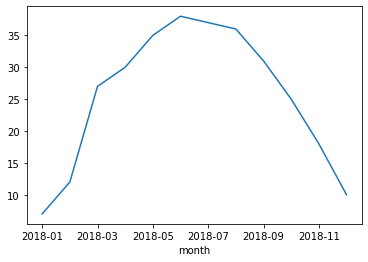

In [34]:
data.plot()

**查看每个月的最高温度、最低温度、平均空气质量指数**

In [35]:
data=df.groupby('month').agg({'bWendu':np.max,'yWendu':np.min, 'aqi':np.mean})

In [37]:
data

bWendu  yWendu         aqi
month                              
2018-01       7     -12   60.677419
2018-02      12     -10   78.857143
2018-03      27      -4  130.322581
2018-04      30       1  102.866667
2018-05      35      10   99.064516
2018-06      38      17   82.300000
2018-07      37      22   72.677419
2018-08      36      20   59.516129
2018-09      31      11   50.433333
2018-10      25       1   67.096774
2018-11      18      -4  105.100000
2018-12      10     -12   77.354839

<AxesSubplot:xlabel='month'>

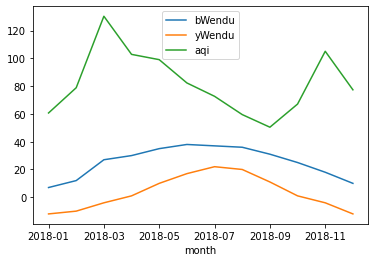

In [36]:
data.plot()